## New code -- Preprocessing

### **Features in This Code**

1. **Grayscale Conversion & Resizing**:  
   Images are resized to \(256 \times 256\) and converted to grayscale.

2. **Normalization**:  
   Pixel values are normalized to the range \([0, 1]\).

3. **Stratified Splitting**:  
   Ensures balanced class distribution in train/test sets.

4. **Class Weights Calculation**:  
   Computes weights for imbalanced classes to improve model training.

5. **Data Augmentation**:  
   Applies transformations such as:
   - **Rotation**: Randomly rotates images.
   - **Shifting**: Horizontally and vertically shifts images.
   - **Zooming**: Randomly zooms into images.
   - **Flipping**: Randomly flips images horizontally.

6. **Visualization**:  
   Displays sample images with their labels for quick verification.

7. **Shape Verification**:  
   Prints dataset shapes to ensure proper preprocessing and readiness for training.

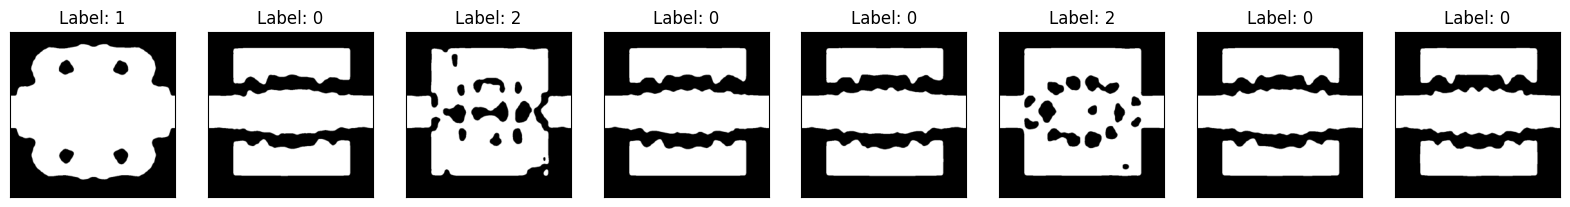

x_train shape: (240, 256, 256, 1), y_train shape: (240,)
x_test shape: (60, 256, 256, 1), y_test shape: (60,)
Class weights: {0: 1.0, 1: 1.0, 2: 1.0}


In [65]:
import os
import numpy as np
from PIL import Image
from sklearn.model_selection import train_test_split, StratifiedShuffleSplit
from sklearn.utils import class_weight
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Parameters
target_size = (256, 256)  # Resize target dimensions
folder_paths = {
    "no_phase": 'Phase_shifter-new/no_phase/no_phase_first100',
    "pi_by_2_phase": 'Phase_shifter-new/pi_by_2_phase/pi_by_2_phase_first100',
    "zero_phase": 'Phase_shifter-new/zero_phase/zero_phase_first100'
}

# Initialize lists for images and labels
x_data = []
y_data = []

# Load and resize grayscale images
for label, path in enumerate(folder_paths.values()):
    for file in os.listdir(path):
        if file.endswith(".bmp"):  # Process only BMP files
            img_path = os.path.join(path, file)
            img = Image.open(img_path).convert('L')  # Convert to grayscale
            img_resized = img.resize(target_size)  # Resize image
            x_data.append(np.array(img_resized))  # Append image as numpy array
            y_data.append(label)  # Append label

# Convert lists to numpy arrays
x_data = np.array(x_data, dtype="float32") / 255.0  # Normalize pixel values to [0, 1]
x_data = np.expand_dims(x_data, axis=-1)  # Add channel dimension for grayscale
y_data = np.array(y_data, dtype="int")  # Convert labels to numpy array

# Stratified splitting for balanced class distribution
sss = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=16)
for train_idx, test_idx in sss.split(x_data, y_data):
    x_train, x_test = x_data[train_idx], x_data[test_idx]
    y_train, y_test = y_data[train_idx], y_data[test_idx]

# Calculate class weights to handle imbalance
class_weights = class_weight.compute_class_weight(
    class_weight='balanced',
    classes=np.unique(y_train),
    y=y_train
)
class_weights = dict(enumerate(class_weights))

# Data augmentation for the training set
datagen = ImageDataGenerator(
    rotation_range=15,
    width_shift_range=0.2,
    height_shift_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True
)
datagen.fit(x_train)

# Display sample images with labels for verification
fig, axes = plt.subplots(1, 8, figsize=(20, 20), subplot_kw={'xticks': [], 'yticks': []})
for i, ax in enumerate(axes.flat):
    ax.imshow(x_train[i].squeeze(), cmap='gray')
    ax.set_title(f"Label: {y_train[i]}")
plt.show()

# Print dataset sizes
print(f"x_train shape: {x_train.shape}, y_train shape: {y_train.shape}")
print(f"x_test shape: {x_test.shape}, y_test shape: {y_test.shape}")
print(f"Class weights: {class_weights}")


### **Steps to Retrain and Save the Model on Phase-Shifter Data**

### New Neural Net Architecture

In [66]:
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, GlobalAveragePooling2D, Dense, Dropout, BatchNormalization, SpatialDropout2D
from keras.regularizers import l2

model = Sequential()

# Convolutional layers
model.add(Conv2D(32, (3, 3), activation='relu', input_shape=(256, 256, 1), kernel_regularizer=l2(0.01)))
model.add(BatchNormalization())
model.add(MaxPooling2D(2, 2))
model.add(SpatialDropout2D(0.3))

model.add(Conv2D(64, (3, 3), activation='relu', kernel_regularizer=l2(0.01)))
model.add(BatchNormalization())
model.add(MaxPooling2D(2, 2))

model.add(Conv2D(128, (3, 3), activation='relu', kernel_regularizer=l2(0.01)))
model.add(BatchNormalization())
model.add(MaxPooling2D(2, 2))

# Global Average Pooling
model.add(GlobalAveragePooling2D())

# Fully connected layers
model.add(Dense(256, activation='relu', kernel_regularizer=l2(0.01)))
model.add(Dropout(0.5))
model.add(Dense(3, activation='softmax'))  # 3 classes

# Compile
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Learning rate scheduler
from keras.callbacks import ReduceLROnPlateau
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5, min_lr=1e-6)

# Display the model architecture
model.summary()


/Users/nayanthara/Library/Python/3.9/lib/python/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_10"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_21 (Conv2D)              │ (None, 254, 254, 32)   │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_21          │ (None, 254, 254, 32)   │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_21 (MaxPooling2D) │ (None, 127, 127, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ spatial_dropout2d_7             │ (None, 127, 127, 32)   │             0 │
│ (SpatialDropout2D)              │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_22 (Conv2D)              │ (None, 125, 125, 64)   │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_22          │ (None, 125, 125, 64)   │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_22 (MaxPooling2D) │ (None, 62, 62, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_23 (Conv2D)              │ (None, 60, 60, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_23          │ (None, 60, 60, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_23 (MaxPooling2D) │ (None, 30, 30, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_7      │ (None, 128)            │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_23 (Dense)                │ (None, 256)            │        33,024 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_13 (Dropout)            │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_24 (Dense)                │ (None, 3)              │           771 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 127,363 (497.51 KB)

 Trainable params: 126,915 (495.76 KB)

 Non-trainable params: 448 (1.75 KB)

In [67]:
from tensorflow.keras.utils import to_categorical

# Convert labels to one-hot encoding
y_train = to_categorical(y_train, num_classes=3)
y_test = to_categorical(y_test, num_classes=3)

# Check the shape of y_train and y_test
print("y_train shape:", y_train.shape)
print("y_test shape:", y_test.shape)

# Train the model
history = model.fit(
    x_train, y_train,
    validation_data=(x_test, y_test),
    batch_size=10,
    epochs=5
)

y_train shape: (240, 3)
y_test shape: (60, 3)
Epoch 1/5
24/24 ━━━━━━━━━━━━━━━━━━━━ 8s 268ms/step - accuracy: 0.4022 - loss: 4.0207 - val_accuracy: 0.3333 - val_loss: 3.7689
Epoch 2/5
24/24 ━━━━━━━━━━━━━━━━━━━━ 6s 255ms/step - accuracy: 0.8701 - loss: 3.1183 - val_accuracy: 0.3333 - val_loss: 3.6526
Epoch 3/5
24/24 ━━━━━━━━━━━━━━━━━━━━ 6s 264ms/step - accuracy: 0.9224 - loss: 2.5689 - val_accuracy: 0.3333 - val_loss: 3.3292
Epoch 4/5
24/24 ━━━━━━━━━━━━━━━━━━━━ 6s 254ms/step - accuracy: 0.9088 - loss: 2.1402 - val_accuracy: 0.3333 - val_loss: 3.1887
Epoch 5/5
24/24 ━━━━━━━━━━━━━━━━━━━━ 6s 257ms/step - accuracy: 0.9638 - loss: 1.7982 - val_accuracy: 0.3333 - val_loss: 2.6754


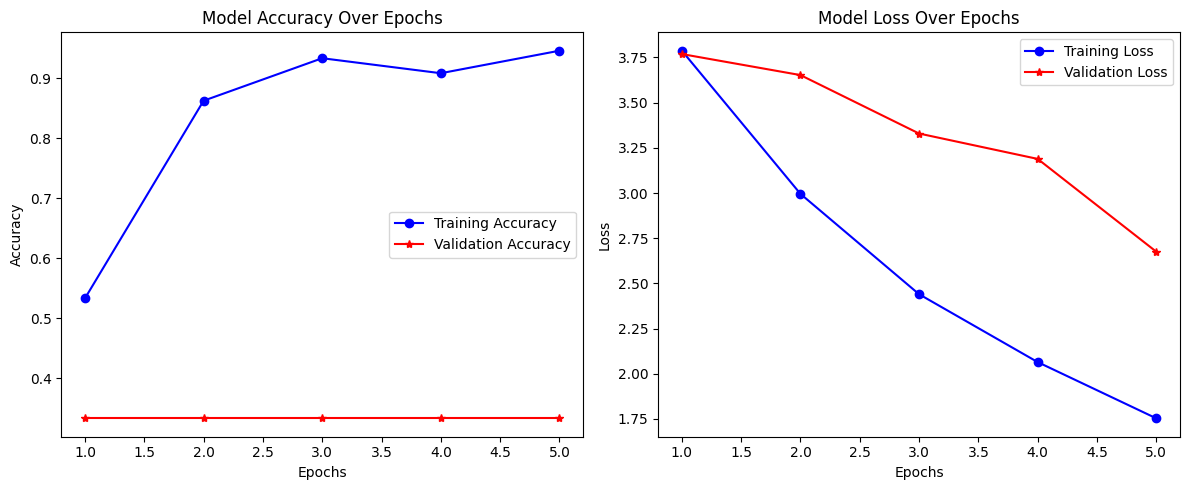

In [68]:
import matplotlib.pyplot as plt

# ✅ Extract values from the history object
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(acc) + 1)

# 🔹 Plot Accuracy
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(epochs, acc, 'bo-', label='Training Accuracy')
plt.plot(epochs, val_acc, 'r*-', label='Validation Accuracy')
plt.title('Model Accuracy Over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

# 🔹 Plot Loss
plt.subplot(1, 2, 2)
plt.plot(epochs, loss, 'bo-', label='Training Loss')
plt.plot(epochs, val_loss, 'r*-', label='Validation Loss')
plt.title('Model Loss Over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()


In [15]:
import os
from lime import lime_image
import sys
from skimage.segmentation import mark_boundaries
import matplotlib.pyplot as plt
import cv2
import numpy as np

# SuppressOutput class definition
class SuppressOutput:
    def __enter__(self):
        self._original_stdout = sys.stdout
        self._original_stderr = sys.stderr
        sys.stdout = open(os.devnull, 'w')
        sys.stderr = open(os.devnull, 'w')

    def __exit__(self, exc_type, exc_value, traceback):
        sys.stdout.close()
        sys.stderr.close()
        sys.stdout = self._original_stdout
        sys.stderr = self._original_stderr

# Combine all images and labels
all_images = np.concatenate((x_train, x_test), axis=0)
all_labels = np.concatenate((y_train, y_test), axis=0)

# Define the prediction function compatible with LIME
def predict_fn(images):
    images = images[:, :, :, 0]  # Extract the first channel (grayscale)
    images = np.expand_dims(images, axis=-1)  # Add back the single channel
    return model.predict(images)  # Model prediction

# Initialize LIME explainer
explainer = lime_image.LimeImageExplainer()

# Define output directory
output_dir = "LIME_Explanations"
os.makedirs(output_dir, exist_ok=True)

# Loop through all images and save LIME explanations
i = 0
for image in all_images:
    # Convert grayscale image to RGB for LIME compatibility
    sample_image = cv2.cvtColor((image.squeeze() * 255).astype('uint8'), cv2.COLOR_GRAY2RGB)

    # Run LIME explanation
    with SuppressOutput():  # Suppress LIME's verbose output
        explanation = explainer.explain_instance(
            sample_image.astype('double'),
            predict_fn,
            top_labels=1,
            hide_color=0,
            num_samples=1000  # Number of perturbations
        )

        # Get the image and mask for the top label
        temp, mask = explanation.get_image_and_mask(
            explanation.top_labels[0],
            positive_only=True,
            num_features=10,
            hide_rest=False
        )

    # Define subfolder for each predicted class
    predicted_class = explanation.top_labels[0]
    class_folder = os.path.join(output_dir, f"Class_{predicted_class}")
    os.makedirs(class_folder, exist_ok=True)

    # Save original image (normalize to [0, 1] for saving)
    original_image_path = os.path.join(class_folder, f"Original_Image_{i}.png")
    plt.imsave(original_image_path, sample_image[:, :, 0] / 255.0, cmap='gray')

    # Save LIME explanation with boundaries (normalize temp)
    explanation_image_path = os.path.join(class_folder, f"LIME_Explanation_{i}.png")
    plt.imsave(explanation_image_path, mark_boundaries(temp / 255.0, mask, color=(1, 1, 0)))

    # Save mask directly
    mask_path = os.path.join(class_folder, f"Mask_{i}.png")
    plt.imsave(mask_path, mask, cmap='gray')

    i += 1  # Increment image counter

print(f"LIME explanations saved in {output_dir}")


LIME explanations saved in LIME_Explanations


In [16]:
import os
import shutil

# Define paths
lime_explanation_dir = "/Users/nayanthara/Desktop/NUS CQT RA/ML Optics Project Lirande/Photonics_LIME/LIME_Explanations/Class_1"  # Directory where explanations are saved
organized_dir = "LIME_Explanations_Organized"  # New directory to organize by class
os.makedirs(organized_dir, exist_ok=True)

# Define class names
class_names = {0: "no_phase", 1: "pi_by_2_phase", 2: "zero_phase"}

# Create subfolders for each class
for class_id, class_name in class_names.items():
    os.makedirs(os.path.join(organized_dir, class_name), exist_ok=True)

# Combine labels (train + test) to match with explanations
all_labels = np.concatenate((y_train, y_test), axis=0)

# Loop through explanations and organize them
for i, label in enumerate(all_labels):  # Use explanation index to match label
    if isinstance(label, np.ndarray):  # If label is one-hot encoded
        label = np.argmax(label)  # Convert to class index

    explanation_file = f"LIME_Explanation_{i}.png"  # Adjust to match your file naming convention
    source_path = os.path.join(lime_explanation_dir, explanation_file)
    if os.path.exists(source_path):
        # Move explanation to the correct class folder
        class_folder = os.path.join(organized_dir, class_names[label])
        shutil.move(source_path, os.path.join(class_folder, explanation_file))

print(f"LIME explanations have been organized by class in {organized_dir}")


LIME explanations have been organized by class in LIME_Explanations_Organized


## **Plots per class and whole Dataset**

### Step 1: Aggregate Masks by Class

In [48]:
import os
import numpy as np
import matplotlib.pyplot as plt
from skimage.io import imread

# Define paths
organized_dir = "LIME_Explanations_Organized"  # Directory where explanations are organized
class_names = ["unconstrained_phase", "pi_by_2_phase", "zero_phase"]  # Adjust as needed

# Initialize a dictionary to store aggregated masks per class
aggregated_masks = {class_name: None for class_name in class_names}

# Loop through each class folder
for class_name in class_names:
    class_folder = os.path.join(organized_dir, class_name)
    for file_name in os.listdir(class_folder):
        if file_name.endswith(".png") and "Mask" in file_name:  # Load only mask files
            mask_path = os.path.join(class_folder, file_name)
            mask = imread(mask_path, as_gray=True)  # Load mask as grayscale
            mask = mask.astype(np.float32)  # Ensure the mask is float for aggregation

            # Aggregate masks
            if aggregated_masks[class_name] is None:
                aggregated_masks[class_name] = mask
            else:
                aggregated_masks[class_name] += mask


In [54]:
import os
import numpy as np
from skimage.io import imread

# Define paths
mask_folder = "LIME_Explanations/Class_1"  # Folder where all masks are stored
class_names = ["unconstrained_phase", "pi_by_2_phase", "zero_phase"]

# Combine labels from train and test sets
all_labels = np.concatenate((y_train, y_test), axis=0)

# Initialize a dictionary to aggregate masks per class
aggregated_masks = {class_name: None for class_name in class_names}
counts_per_class = {class_name: 0 for class_name in class_names}  # Count of masks per class

# Organize masks by class
for i, label in enumerate(all_labels):  # Match masks with labels
    if isinstance(label, np.ndarray):  # If label is one-hot encoded
        label = np.argmax(label)  # Convert one-hot encoding to class index

    class_name = class_names[label]  # Map label to class name
    mask_path = os.path.join(mask_folder, f"Mask_{i}.png")  # Construct mask file name
    if os.path.exists(mask_path):
        mask = imread(mask_path, as_gray=True).astype(np.float32)  # Load mask as grayscale

        # Aggregate masks for the class
        if aggregated_masks[class_name] is None:
            aggregated_masks[class_name] = mask
        else:
            aggregated_masks[class_name] += mask

        counts_per_class[class_name] += 1


In [55]:
print(f"Label: {label}, Class Name: {class_name}, Mask Path: {mask_path}")


Label: 0, Class Name: unconstrained_phase, Mask Path: LIME_Explanations/Class_1/Mask_299.png


### Step 2: Normalize and Plot Per-Class Aggregated Heatmaps

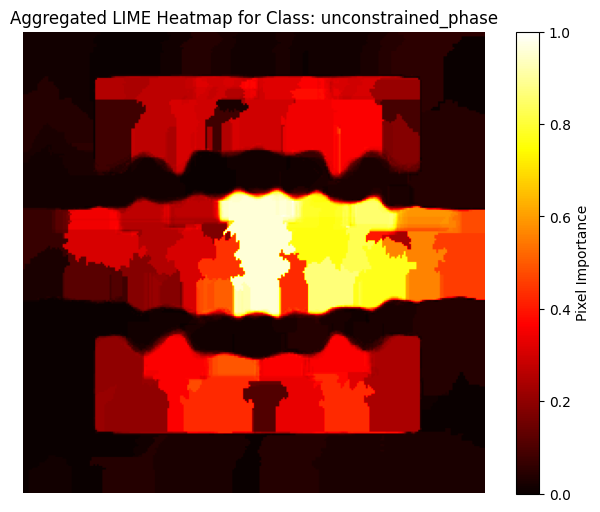

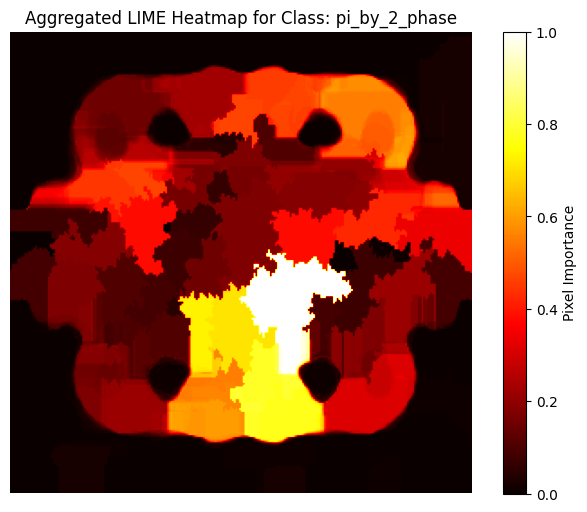

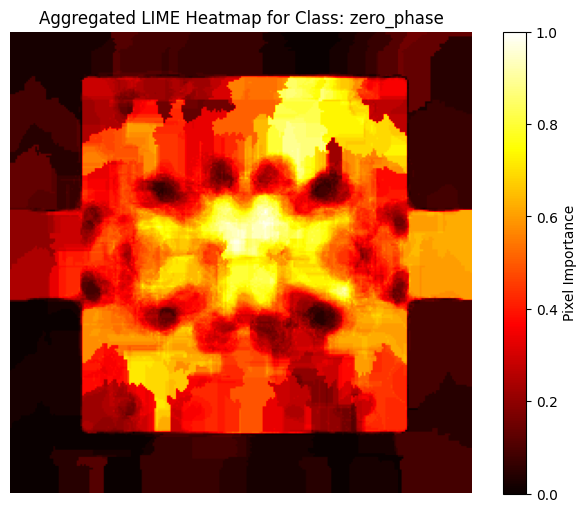

In [56]:
# Plot aggregated heatmaps per class
for class_name, mask in aggregated_masks.items():
    if mask is not None:
        # Normalize mask to [0, 1]
        normalized_mask = mask / mask.max()

        # Plot heatmap
        plt.figure(figsize=(8, 6))
        plt.title(f"Aggregated LIME Heatmap for Class: {class_name}")
        plt.imshow(normalized_mask, cmap="hot")
        plt.colorbar(label="Pixel Importance")
        plt.axis("off")
        plt.show()


### Step 3: Compare Classes Side-by-Side

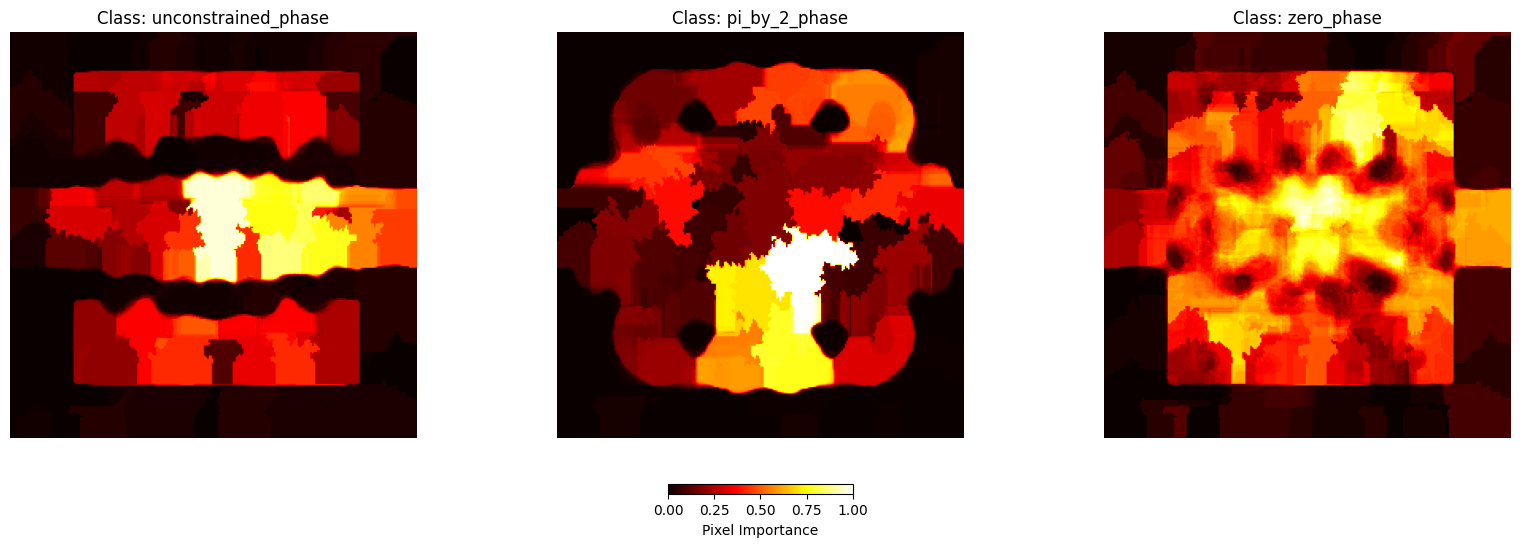

In [57]:
# Plot side-by-side comparisons
fig, axes = plt.subplots(1, len(class_names), figsize=(20, 6))
im = None  # Initialize 'im' for the colorbar

for i, (class_name, mask) in enumerate(aggregated_masks.items()):
    if mask is not None:
        # Normalize mask
        normalized_mask = mask / mask.max()

        # Plot heatmap
        ax = axes[i]
        ax.set_title(f"Class: {class_name}")
        im = ax.imshow(normalized_mask, cmap="hot")  # Assign the heatmap to 'im'
        ax.axis("off")

# Add a single colorbar for all subplots
if im is not None:
    fig.colorbar(im, ax=axes, orientation="horizontal", fraction=0.02, pad=0.1, label="Pixel Importance")

plt.show()


### Step 4: Overall Aggregate Heatmap for Entire Dataset

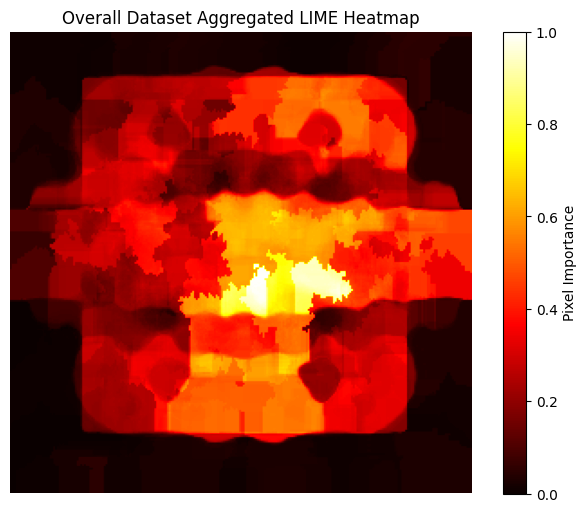

In [58]:
# Aggregate all masks into a single heatmap
overall_mask = None
for class_name, mask in aggregated_masks.items():
    if mask is not None:
        if overall_mask is None:
            overall_mask = mask
        else:
            overall_mask += mask

# Normalize and plot overall heatmap
if overall_mask is not None:
    normalized_overall_mask = overall_mask / overall_mask.max()

    plt.figure(figsize=(8, 6))
    plt.title("Overall Dataset Aggregated LIME Heatmap")
    plt.imshow(normalized_overall_mask, cmap="hot")
    plt.colorbar(label="Pixel Importance")
    plt.axis("off")
    plt.show()


### Step 5: Confidence per Class

In [27]:
# Combine train and test images
all_images = np.concatenate((x_train, x_test), axis=0)

# Generate predictions
predictions = model.predict(all_images)  # predictions.shape = (num_samples, num_classes)


10/10 ━━━━━━━━━━━━━━━━━━━━ 2s 195ms/step


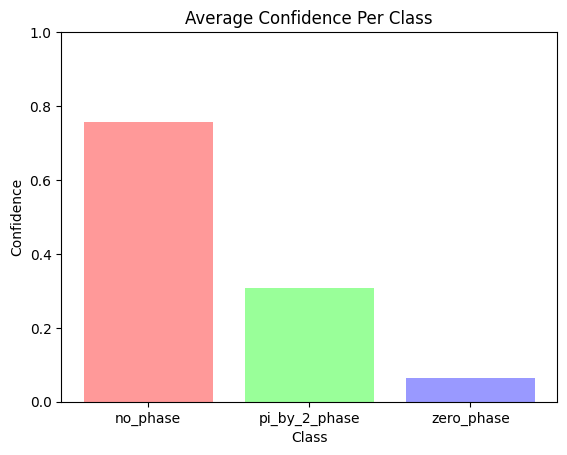

In [59]:
import numpy as np
import matplotlib.pyplot as plt

# Define class names
class_names = ["no_phase", "pi_by_2_phase", "zero_phase"]

# Initialize storage for confidence scores
class_confidences = {class_name: [] for class_name in class_names}

# Collect confidence scores per class
for i, true_label in enumerate(all_labels):  # Assuming `all_labels` contains true labels
    if isinstance(true_label, np.ndarray):  # Handle one-hot encoding
        true_label = np.argmax(true_label)  # Convert one-hot to scalar
    class_name = class_names[true_label]

    # Extract the confidence for the true class
    confidence = predictions[i][true_label]
    class_confidences[class_name].append(confidence)

# Compute average confidence per class
average_confidences = {class_name: np.mean(scores) for class_name, scores in class_confidences.items()}

# Plot average confidence per class
plt.bar(class_confidences.keys(), average_confidences.values(), color=['#FF9999', '#99FF99', '#9999FF'])
plt.title("Average Confidence Per Class")
plt.xlabel("Class")
plt.ylabel("Confidence")
plt.ylim(0, 1)  # Confidence is between 0 and 1
plt.show()


/var/folders/qw/p8rpb13x5xdcc1g501wf9mdw0000gn/T/ipykernel_79616/1162420978.py:5: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot(confidence_data, labels=class_confidences.keys(), patch_artist=True)


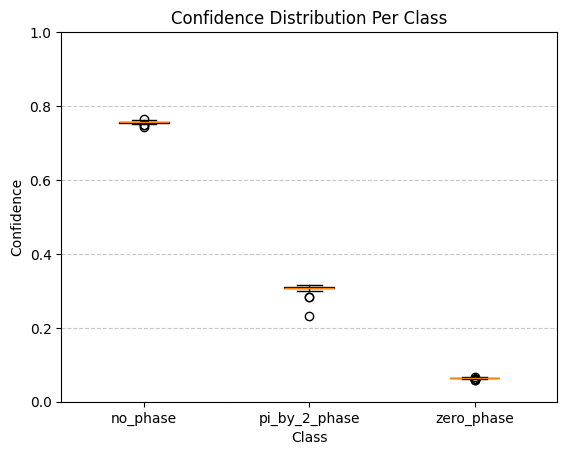

In [60]:
# Prepare confidence data for box plot
confidence_data = [scores for scores in class_confidences.values()]

# Plot box plot for confidence distribution
plt.boxplot(confidence_data, labels=class_confidences.keys(), patch_artist=True)
plt.title("Confidence Distribution Per Class")
plt.xlabel("Class")
plt.ylabel("Confidence")
plt.ylim(0, 1)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()


# **Checking Model Details**

In [31]:
from tensorflow.keras.models import load_model

# Load both models
model_keras = load_model("my_model.keras")
model_h5 = load_model("my_trained_model.h5")

# Print model names and summaries
print(f"Model from 'my_model.keras': {model_keras.name}")
print(model_keras.summary())

print(f"\nModel from 'my_trained_model.h5': {model_h5.name}")
print(model_h5.summary())


TypeError: Could not deserialize class 'Functional' because its parent module keras.src.engine.functional cannot be imported. Full object config: {'module': 'keras.src.engine.functional', 'class_name': 'Functional', 'config': {'name': 'model', 'trainable': True, 'layers': [{'module': 'keras.layers', 'class_name': 'InputLayer', 'config': {'batch_input_shape': [None, 128, 128, 1], 'dtype': 'float32', 'sparse': False, 'ragged': False, 'name': 'input_1'}, 'registered_name': None, 'name': 'input_1', 'inbound_nodes': []}, {'module': 'keras.layers', 'class_name': 'Conv2D', 'config': {'name': 'conv2d', 'trainable': True, 'dtype': 'float32', 'filters': 32, 'kernel_size': [3, 3], 'strides': [1, 1], 'padding': 'same', 'data_format': 'channels_last', 'dilation_rate': [1, 1], 'groups': 1, 'activation': 'relu', 'use_bias': True, 'kernel_initializer': {'module': 'keras.initializers', 'class_name': 'GlorotUniform', 'config': {'seed': None}, 'registered_name': None}, 'bias_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'kernel_regularizer': None, 'bias_regularizer': None, 'activity_regularizer': None, 'kernel_constraint': None, 'bias_constraint': None}, 'registered_name': None, 'build_config': {'input_shape': [None, 128, 128, 1]}, 'name': 'conv2d', 'inbound_nodes': [[['input_1', 0, 0, {}]]]}, {'module': 'keras.layers', 'class_name': 'MaxPooling2D', 'config': {'name': 'max_pooling2d', 'trainable': True, 'dtype': 'float32', 'pool_size': [2, 2], 'padding': 'same', 'strides': [2, 2], 'data_format': 'channels_last'}, 'registered_name': None, 'build_config': {'input_shape': [None, 128, 128, 32]}, 'name': 'max_pooling2d', 'inbound_nodes': [[['conv2d', 0, 0, {}]]]}, {'module': 'keras.layers', 'class_name': 'Conv2D', 'config': {'name': 'conv2d_1', 'trainable': True, 'dtype': 'float32', 'filters': 64, 'kernel_size': [3, 3], 'strides': [1, 1], 'padding': 'same', 'data_format': 'channels_last', 'dilation_rate': [1, 1], 'groups': 1, 'activation': 'relu', 'use_bias': True, 'kernel_initializer': {'module': 'keras.initializers', 'class_name': 'GlorotUniform', 'config': {'seed': None}, 'registered_name': None}, 'bias_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'kernel_regularizer': None, 'bias_regularizer': None, 'activity_regularizer': None, 'kernel_constraint': None, 'bias_constraint': None}, 'registered_name': None, 'build_config': {'input_shape': [None, 64, 64, 32]}, 'name': 'conv2d_1', 'inbound_nodes': [[['max_pooling2d', 0, 0, {}]]]}, {'module': 'keras.layers', 'class_name': 'MaxPooling2D', 'config': {'name': 'max_pooling2d_1', 'trainable': True, 'dtype': 'float32', 'pool_size': [2, 2], 'padding': 'same', 'strides': [2, 2], 'data_format': 'channels_last'}, 'registered_name': None, 'build_config': {'input_shape': [None, 64, 64, 64]}, 'name': 'max_pooling2d_1', 'inbound_nodes': [[['conv2d_1', 0, 0, {}]]]}, {'module': 'keras.layers', 'class_name': 'Conv2D', 'config': {'name': 'conv2d_2', 'trainable': True, 'dtype': 'float32', 'filters': 64, 'kernel_size': [3, 3], 'strides': [1, 1], 'padding': 'same', 'data_format': 'channels_last', 'dilation_rate': [1, 1], 'groups': 1, 'activation': 'relu', 'use_bias': True, 'kernel_initializer': {'module': 'keras.initializers', 'class_name': 'GlorotUniform', 'config': {'seed': None}, 'registered_name': None}, 'bias_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'kernel_regularizer': None, 'bias_regularizer': None, 'activity_regularizer': None, 'kernel_constraint': None, 'bias_constraint': None}, 'registered_name': None, 'build_config': {'input_shape': [None, 32, 32, 64]}, 'name': 'conv2d_2', 'inbound_nodes': [[['max_pooling2d_1', 0, 0, {}]]]}, {'module': 'keras.layers', 'class_name': 'UpSampling2D', 'config': {'name': 'up_sampling2d', 'trainable': True, 'dtype': 'float32', 'size': [2, 2], 'data_format': 'channels_last', 'interpolation': 'nearest'}, 'registered_name': None, 'build_config': {'input_shape': [None, 32, 32, 64]}, 'name': 'up_sampling2d', 'inbound_nodes': [[['conv2d_2', 0, 0, {}]]]}, {'module': 'keras.layers', 'class_name': 'Conv2D', 'config': {'name': 'conv2d_3', 'trainable': True, 'dtype': 'float32', 'filters': 32, 'kernel_size': [3, 3], 'strides': [1, 1], 'padding': 'same', 'data_format': 'channels_last', 'dilation_rate': [1, 1], 'groups': 1, 'activation': 'relu', 'use_bias': True, 'kernel_initializer': {'module': 'keras.initializers', 'class_name': 'GlorotUniform', 'config': {'seed': None}, 'registered_name': None}, 'bias_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'kernel_regularizer': None, 'bias_regularizer': None, 'activity_regularizer': None, 'kernel_constraint': None, 'bias_constraint': None}, 'registered_name': None, 'build_config': {'input_shape': [None, 64, 64, 64]}, 'name': 'conv2d_3', 'inbound_nodes': [[['up_sampling2d', 0, 0, {}]]]}, {'module': 'keras.layers', 'class_name': 'UpSampling2D', 'config': {'name': 'up_sampling2d_1', 'trainable': True, 'dtype': 'float32', 'size': [2, 2], 'data_format': 'channels_last', 'interpolation': 'nearest'}, 'registered_name': None, 'build_config': {'input_shape': [None, 64, 64, 32]}, 'name': 'up_sampling2d_1', 'inbound_nodes': [[['conv2d_3', 0, 0, {}]]]}, {'module': 'keras.layers', 'class_name': 'Conv2D', 'config': {'name': 'conv2d_4', 'trainable': True, 'dtype': 'float32', 'filters': 1, 'kernel_size': [3, 3], 'strides': [1, 1], 'padding': 'same', 'data_format': 'channels_last', 'dilation_rate': [1, 1], 'groups': 1, 'activation': 'sigmoid', 'use_bias': True, 'kernel_initializer': {'module': 'keras.initializers', 'class_name': 'GlorotUniform', 'config': {'seed': None}, 'registered_name': None}, 'bias_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'kernel_regularizer': None, 'bias_regularizer': None, 'activity_regularizer': None, 'kernel_constraint': None, 'bias_constraint': None}, 'registered_name': None, 'build_config': {'input_shape': [None, 128, 128, 32]}, 'name': 'conv2d_4', 'inbound_nodes': [[['up_sampling2d_1', 0, 0, {}]]]}], 'input_layers': [['input_1', 0, 0]], 'output_layers': [['conv2d_4', 0, 0]]}, 'registered_name': 'Functional', 'build_config': {'input_shape': [None, 128, 128, 1]}, 'compile_config': {'optimizer': 'adam', 'loss': 'binary_crossentropy', 'metrics': None, 'loss_weights': None, 'weighted_metrics': None, 'run_eagerly': None, 'steps_per_execution': None, 'jit_compile': None}}